In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_ellipse(Q, center=(0, 0), scale=1):
    def normalize_matrix(A, norm_type='fro'):
        norm = np.linalg.norm(A, 'fro') if norm_type == 'fro' else np.max(np.abs(A))
        return A / norm if norm else A
    Q = normalize_matrix(Q)

    def swap_principal_axes(Q):
        eigvals, eigvecs = np.linalg.eigh(Q)
        return eigvecs @ np.diag(eigvals[::-1]) @ eigvecs.T

    Q = swap_principal_axes(Q)
    
    if Q[0,0] < 0:
        Q = -Q

    eigenvalues, eigenvectors = np.linalg.eigh(Q)
    if np.any(eigenvalues < 0):
        return np.nan, np.nan
    a, b = np.sqrt(eigenvalues) * scale
    theta = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0])
    t = np.linspace(0, 2 * np.pi, 100)
    x, y = a * np.cos(t), b * np.sin(t)
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    x_ellipse, y_ellipse = R @ np.array([x, y]) + np.array(center).reshape(2, 1)
    return x_ellipse, y_ellipse

## Field Generation

(np.float64(0.0), np.float64(100.0), np.float64(0.0), np.float64(100.0))

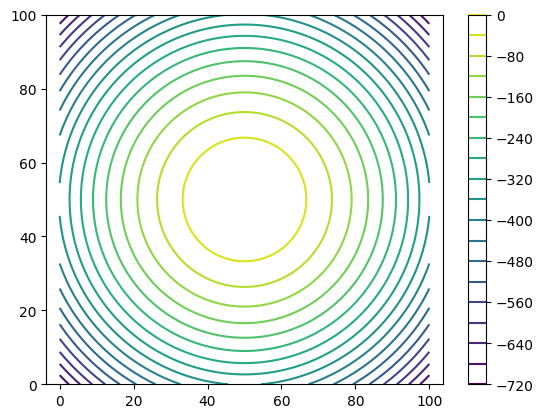

In [2]:
width=500

x_circ = np.linspace(-width // 2, width // 2, 101)  
y_circ = np.linspace(-width // 2, width // 2, 101)
X_circ, Y_circ = np.meshgrid(x_circ, y_circ)

x0_circ, y0_circ = 0, 0

A_circ = -2/350
Psi_circ = A_circ*( (X_circ-x0_circ)**2 + (Y_circ-y0_circ)**2 )

u_circ, v_circ = (-2*A_circ*(Y_circ - y0_circ)).T, (2*A_circ*(X_circ - x0_circ)).T

plt.contour(Psi_circ, 20)
plt.colorbar()
plt.axis('equal')



(np.float64(-250.0), np.float64(250.0), np.float64(-250.0), np.float64(250.0))

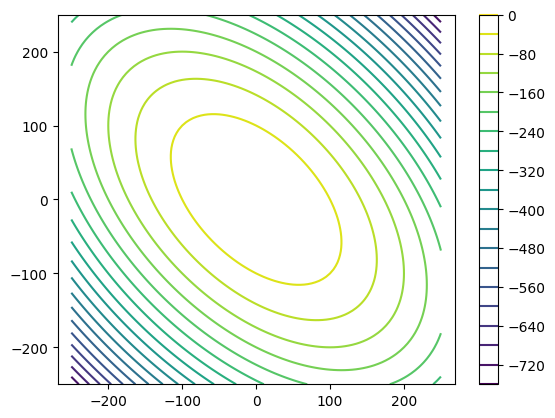

In [3]:
width=500

x_ell = np.linspace(-width // 2, width // 2, 101)  
y_ell = np.linspace(-width // 2, width // 2, 101) 
X_ell, Y_ell = np.meshgrid(x_ell, y_ell)

x0_ell, y0_ell = 0, 0

q11, q22, q12 = 2, 2, 1
A_ell = -1/500
q11 *= A_ell
q22 *= A_ell
q12 *= A_ell
Q = np.array([[q11, q12], [q12, q22]])

XY = np.stack((X_ell, Y_ell), axis=-1)  # Shape (101, 101, 2)
Psi_ell = np.einsum("...i,ij,...j->...", XY, Q, XY)

u_ell = (-2*q22*(Y_ell-y0_ell) - 2*q12*(X_ell-x0_ell)).T
v_ell =  (2*q11*(X_ell-x0_ell) + 2*q12*(Y_ell-y0_ell)).T

plt.contour(X_ell, Y_ell, Psi_ell, 20)
plt.colorbar()
plt.axis('equal')

## MOCA

In [4]:
def find_root(x, y):
    coeffs = np.polyfit(x, y, 3)
    roots = np.roots(np.poly1d(coeffs))
    real_roots = roots[np.isreal(roots)].real
    mid = x[len(x)//2]
    return real_roots[np.argmin(np.abs(mid - real_roots))]

def tang_at_root(x, y, rx):
    coeffs = np.polyfit(x, y, 3)
    deriv = np.polyder(coeffs)
    slope = np.polyval(deriv, rx)
    intercept = np.polyval(coeffs, rx) - slope * rx
    return slope, intercept

def cubic_interpolate(x, y, root):
    coeffs = np.polyfit(x, y, 3)
    return np.polyval(coeffs, root)

def moca(u, v, x, y, n_ic, n_jc, r=20):
    # Extract vertical profile at column n_jc
    u1 = u[n_ic - r:n_ic + r + 1, n_jc]
    v1 = v[n_ic - r:n_ic + r + 1, n_jc]
    xx = x[n_ic - r:n_ic + r + 1]
    base = xx[0]
    l = xx - base
    yy = np.full_like(xx, y[n_jc])
    
    root = find_root(l, v1)
    c, b = tang_at_root(l, v1, root)  # c: slope, b: intercept
    a = cubic_interpolate(l, u1, root)
    
    x0 = -b / c + base
    y0 = a / c + yy[0]
    w = 2 * c
    
    return x0, y0, l, xx, yy, u1, v1, a, b, c  

nic = 50
njc = 70

x0_circ, y0_circ, l_circ, xx_circ, yy_circ, u1_circ, v1_circ, a_circ, b_circ, c_circ = moca(u_circ, v_circ, x_circ, y_circ, nic, njc)
x0_ell, y0_ell, l_ell, xx_ell, yy_ell, u1_ell, v1_ell, a_ell, b_ell, c_ell = moca(u_ell, v_ell, x_ell, y_ell, nic, njc)


## DOPPIO

In [5]:

def find_root(x, y, degree=3):
    """Fit a degree-3 polynomial to (x, y) and return the real root closest to x's midpoint."""
    coeffs = np.polyfit(x, y, degree)
    roots = np.roots(np.poly1d(coeffs))
    real_roots = roots[np.isreal(roots)].real
    mid_x = x[len(x) // 2]
    return real_roots[np.argmin(np.abs(real_roots - mid_x))]

def tangent_at_root(x, y, root_x, degree=3):
    coeffs = np.polyfit(x, y, degree)
    slope = np.polyval(np.polyder(coeffs), root_x)
    intercept = np.polyval(coeffs, root_x) - slope * root_x
    y_fit = np.polyval(coeffs, x)
    r2 = 1 - np.sum((y - y_fit)**2) / np.sum((y - np.mean(y))**2) if np.sum((y - np.mean(y))**2) != 0 else 1.0
    return slope, intercept, r2

def dopioe(nic, njc, r, u, v, X, Y):

    # Vertical profile along column njc
    u1 = u[nic - r: nic + r + 1, njc]
    v1 = v[nic - r: nic + r + 1, njc]
    x1 = X.T[nic - r: nic + r + 1, njc]
    y1 = Y.T[nic - r: nic + r + 1, njc]
    center_x = X.T[nic, njc]
    xx = x1 - center_x

    # Horizontal profile along row nic
    u2 = u[nic, njc - r: njc + r + 1]
    v2 = v[nic, njc - r: njc + r + 1]
    x2 = X.T[nic, njc - r: njc + r + 1]
    y2 = Y.T[nic, njc - r: njc + r + 1]
    center_y = Y.T[nic, njc]
    yy = y2 - center_y

    # Compute roots and tangents
    root_x = find_root(xx, v1)
    A1, A0, r2A = tangent_at_root(xx, u1, root_x)
    B1, B0, r2B = tangent_at_root(xx, v1, root_x)
    
    root_y = find_root(yy, u2)
    C1, C0, r2C = tangent_at_root(yy, u2, root_y)
    D1, D0, r2D = tangent_at_root(yy, v2, root_y)
    
    alpha = A0 if r2A > r2C else C0
    beta  = B0 if r2B > r2D else D0
    gamma = A1 if r2A > r2D else -D1
    
    q11 = B1 / 2
    q22 = -C1 / 2
    q12 = -gamma / 2
    denom = C1 * B1 + gamma**2
    if denom == 0:
        raise ZeroDivisionError("Denominator is zero.")
        
    x0 = - (alpha * gamma + beta * C1) / denom
    y0 = (beta * gamma - alpha * B1) / denom
    w = 2 * (q11 + q22)

    Q = np.array([[q11, q12], [q12, q22]])

    return x0 + center_x, y0 + center_y, w, x1, y1, u1, v1, x2, y2, u2, v2, xx, yy, Q

nic = 65
njc = 65
r = 20

x0_circ2, y0_circ2, w_circ2, x1_circ2, y1_circ2, u1_circ2, v1_circ2, x2_circ2, y2_circ2, u2_circ2, v2_circ2, xx_circ2, yy_circ2, Q_circ2 = dopioe(nic, njc, r, u_circ, v_circ, X_circ, Y_circ)
x0_ell2, y0_ell2, w_ell2, x1_ell2, y1_ell2, u1_ell2, v1_ell2, x2_ell2, y2_ell2, u2_ell2, v2_ell2, xx_ell2, yy_ell2, Q_ell2 = dopioe(nic, njc, r, u_ell, v_ell, X_ell, Y_ell)




## Final Plot

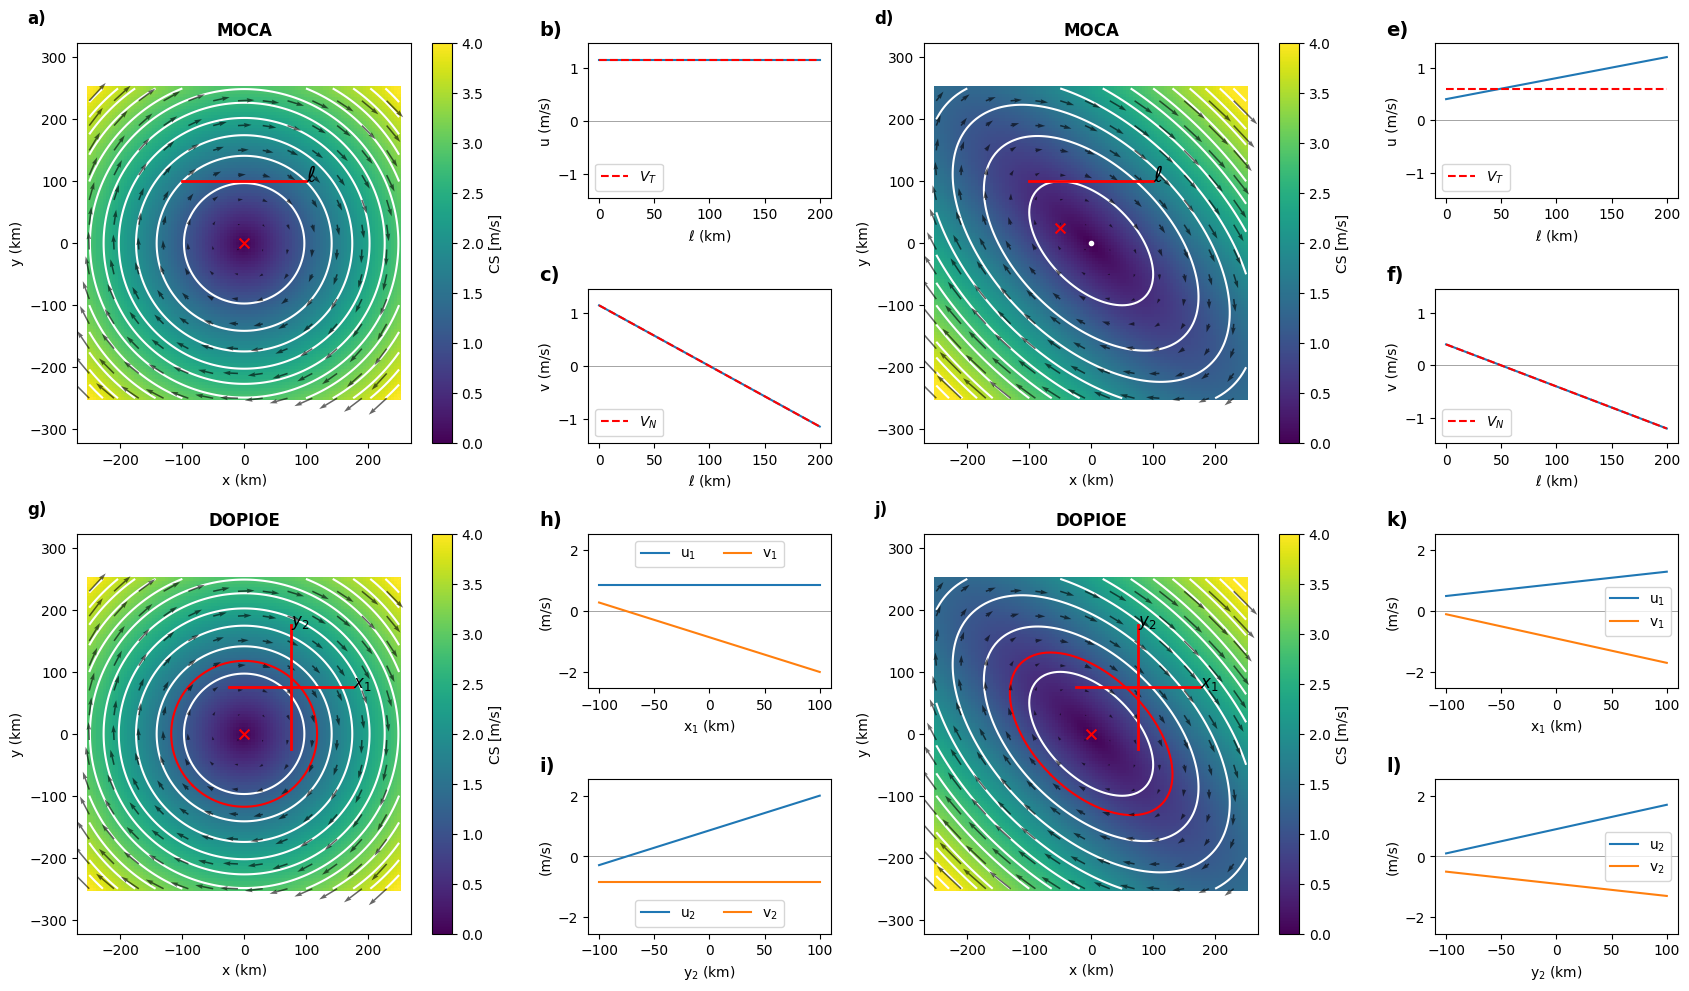

In [42]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(17, 10))
gs = gridspec.GridSpec(4, 6, figure=fig, width_ratios=[2, 2, 3, 2, 2, 3]) 
alpha = .6
spacing = 8
Q_scale = 140

##### 1 #####

#1 LEFT PLOT (PLOT A)
ax_main_left = fig.add_subplot(gs[:2, :2])
pcm = ax_main_left.pcolor(X_circ, Y_circ, np.hypot(u_circ, v_circ).T, vmin=0, vmax=4)
# cbar = fig.colorbar(pcm, ax=ax_main_left, orientation='horizontal', location='top', label='CS [m/s]')
cbar = fig.colorbar(pcm, ax=ax_main_left, orientation='vertical', location='right', label='CS [m/s]')
levels = range(int(np.min(Psi_circ)), int(np.max(Psi_circ)), 60)
ax_main_left.contour(X_circ, Y_circ, Psi_circ, levels=levels, colors='w', linestyles='-')
ax_main_left.quiver(X_circ[::spacing, ::spacing], Y_circ[::spacing, ::spacing],
            u_circ[::spacing, ::spacing].T, v_circ[::spacing, ::spacing].T, zorder=3, alpha=alpha)
ax_main_left.plot(xx_circ, yy_circ, 'r', linewidth=2, zorder=3)
ax_main_left.text(xx_circ[-1], yy_circ[-1], r'$\ell$', color='k', fontweight='bold', fontsize=16)
# ax_main_left.scatter(0, 0, color='w', marker='.')
ax_main_left.scatter(x0_circ, y0_circ, color='r', marker='x', s=50, zorder=4)
ax_main_left.set_title('MOCA', fontweight='bold')
ax_main_left.set_xlabel('x (km)')
ax_main_left.set_ylabel('y (km)')
ax_main_left.axis('equal')
ax_main_left.text(-0.15, 1.05, 'a)', transform=ax_main_left.transAxes, fontsize=12, fontweight='bold')

#1 Subplot columns (2x1 on the right)
ax2_left = fig.add_subplot(gs[0, 2])
ax3_left = fig.add_subplot(gs[1, 2])

axs = [ax2_left, ax3_left]
root = find_root(l_circ, v1_circ)
c, b = tang_at_root(l_circ, v1_circ, root)
a = cubic_interpolate(l_circ, u1_circ, root)
p_v1 = c*l_circ + b
p_u1 = [a]*len(l_circ)
for ax, data, ylabel, p in zip(axs, [u1_circ, v1_circ], ['u (m/s)', 'v (m/s)'], [0, 1]):
    ax.plot(l_circ, data)
    ax.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(r'$\ell$ (km)')

ax2_left.plot(l_circ, p_u1, '--r', label=r'$V_T$')
ax3_left.plot(l_circ, p_v1, '--r', label=r'$V_N$')
ax2_left.legend(loc='lower left')
ax3_left.legend(loc='lower left')

ymin, ymax = min(ax.get_ylim()[0] for ax in axs), max(ax.get_ylim()[1] for ax in axs)
for ax in axs:
    ax.set_ylim(ymin -.2, ymax + .2)

ax2_left.text(-0.2, 1.15, 'b)', transform=ax2_left.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
ax3_left.text(-0.2, 1.15, 'c)', transform=ax3_left.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

#1 RIGHT PLOT (PLOT B)
ax_main_right = fig.add_subplot(gs[:2, 3:5])
pcm = ax_main_right.pcolor(X_ell, Y_ell, np.hypot(u_ell, v_ell).T, vmin=0, vmax=4)
# cbar = fig.colorbar(pcm, ax=ax_main_right, orientation='horizontal', location='top', label='CS [m/s]')
cbar = fig.colorbar(pcm, ax=ax_main_right, orientation='vertical', location='right', label='CS [m/s]')
levels = range(int(np.min(Psi_ell)), int(np.max(Psi_ell)), 60)
ax_main_right.contour(X_ell, Y_ell, Psi_ell, levels=levels, colors='w', linestyles='-')
ax_main_right.quiver(X_ell[::spacing, ::spacing], Y_ell[::spacing, ::spacing],
             u_ell[::spacing, ::spacing].T, v_ell[::spacing, ::spacing].T, zorder=3, alpha=alpha)
ax_main_right.plot(xx_ell, yy_ell, 'r', linewidth=2, zorder=3)
ax_main_right.text(xx_ell[-1], yy_ell[-1], r'$\ell$', color='k', fontweight='bold', fontsize=16)
ax_main_right.scatter(0, 0, color='w', marker='.')
ax_main_right.scatter(x0_ell, y0_ell, color='r', marker='x', s=50, zorder=4)
ax_main_right.set_title('MOCA', fontweight='bold')
ax_main_right.set_xlabel('x (km)')
ax_main_right.set_ylabel('y (km)')
ax_main_right.axis('equal')
ax_main_right.text(-0.15, 1.05, 'd)', transform=ax_main_right.transAxes, fontsize=12, fontweight='bold', color='k')

#1 Subplot columns (2x1 on the right)
ax2_right = fig.add_subplot(gs[0, 5])
ax3_right = fig.add_subplot(gs[1, 5])

axs = [ax2_right, ax3_right]
root = find_root(l_ell, v1_ell)
c, b = tang_at_root(l_ell, v1_ell, root)
a = cubic_interpolate(l_ell, u1_ell, root)
p_v1 = c*l_ell + b
p_u1 = [a]*len(l_ell)
for ax, data, ylabel, p in zip(axs, [u1_ell, v1_ell], ['u (m/s)', 'v (m/s)'], [0, 1]):
    ax.plot(l_ell, data)
    ax.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(r'$\ell$ (km)')

ax2_right.plot(l_ell, p_u1, '--r', label=r'$V_T$')
ax3_right.plot(l_ell, p_v1, '--r', label=r'$V_N$')
ax2_right.legend(loc='lower left')
ax3_right.legend(loc='lower left')
    
ymin, ymax = min(ax.get_ylim()[0] for ax in axs), max(ax.get_ylim()[1] for ax in axs)
for ax in axs:
    ax.set_ylim(ymin -.2, ymax + .2)

ax2_right.text(-0.2, 1.15, 'e)', transform=ax2_right.transAxes, fontsize=14, fontweight='bold', va='top', ha='left', color='k')
ax3_right.text(-0.2, 1.15, 'f)', transform=ax3_right.transAxes, fontsize=14, fontweight='bold', va='top', ha='left', color='k')

##### 2 #####

#2 LEFT PLOT (PLOT A)
ax_main_left = fig.add_subplot(gs[2:, :2])
pcm = ax_main_left.pcolor(X_circ, Y_circ, np.hypot(u_circ, v_circ).T, vmin=0, vmax=4)
# cbar = fig.colorbar(pcm, ax=ax_main_left, orientation='horizontal', location='top', label='CS [m/s]')
cbar = fig.colorbar(pcm, ax=ax_main_left, orientation='vertical', location='right', label='CS [m/s]')
levels = range(int(np.min(Psi_circ)), int(np.max(Psi_circ)), 60)
ax_main_left.contour(X_circ, Y_circ, Psi_circ, levels=levels, colors='w', linestyles='-')
ax_main_left.quiver(X_circ[::spacing, ::spacing], Y_circ[::spacing, ::spacing],
            u_circ[::spacing, ::spacing].T, v_circ[::spacing, ::spacing].T, zorder=3, alpha=alpha)
ax_main_left.plot(x1_circ2, y1_circ2, 'r', linewidth=2, zorder=3)
ax_main_left.plot(x2_circ2, y2_circ2, 'r', linewidth=2, zorder=3)
ax_main_left.text(x1_circ2[-1], y1_circ2[-1], r'$x_1$', color='k', fontweight='bold', fontsize=12)
ax_main_left.text(x2_circ2[-1], y2_circ2[-1], r'$y_2$', color='k', fontweight='bold', fontsize=12)
# ax_main_left.scatter(0, 0, color='w', marker='.')
ax_main_left.scatter(x0_circ2, y0_circ2, color='r', marker='x', s=50, zorder=4)

x_ellipse, y_ellipse = plot_ellipse(Q_circ2, center=(0, 0), scale=Q_scale)
ax_main_left.plot(x_ellipse, y_ellipse, 'r')

ax_main_left.set_title('DOPIOE', fontweight='bold')
ax_main_left.set_xlabel('x (km)')
ax_main_left.set_ylabel('y (km)')
ax_main_left.axis('equal')
ax_main_left.text(-0.15, 1.05, 'g)', transform=ax_main_left.transAxes, fontsize=12, fontweight='bold', color='k')

#2 Subplot columns (2x1 on the right)
ax2_left = fig.add_subplot(gs[2, 2])
ax3_left = fig.add_subplot(gs[3, 2])

ax2_left.plot(xx_circ2, u1_circ2, label=r'u$_1$')
ax2_left.plot(xx_circ2, v1_circ2, label=r'v$_1$')
ax2_left.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax2_left.set_ylabel('(m/s)')
ax2_left.set_xlabel(r'x$_1$ (km)')
ax2_left.legend(loc='upper center', ncol=2)
ax3_left.plot(yy_circ2, u2_circ2, label=r'u$_2$')
ax3_left.plot(yy_circ2, v2_circ2, label=r'v$_2$')
ax3_left.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax3_left.set_ylabel('(m/s)')
ax3_left.set_xlabel(r'y$_2$ (km)')
ax3_left.legend(loc='lower center', ncol=2)

ax2_left.text(-0.2, 1.15, 'h)', transform=ax2_left.transAxes, fontsize=14, fontweight='bold', va='top', ha='left', color='k')
ax3_left.text(-0.2, 1.15, 'i)', transform=ax3_left.transAxes, fontsize=14, fontweight='bold', va='top', ha='left', color='k')

axs = [ax2_left, ax3_left]
ymin, ymax = min(ax.get_ylim()[0] for ax in axs), max(ax.get_ylim()[1] for ax in axs)
for ax in axs:
    ax.set_ylim(ymin -.2, ymax + .2)

#2 RIGHT PLOT (PLOT B)
ax_main_right = fig.add_subplot(gs[2:, 3:5])
pcm = ax_main_right.pcolor(X_ell, Y_ell, np.hypot(u_ell, v_ell).T, vmin=0, vmax=4)
# cbar = fig.colorbar(pcm, ax=ax_main_right, orientation='horizontal', location='top', label='CS [m/s]')
cbar = fig.colorbar(pcm, ax=ax_main_right, orientation='vertical', location='right', label='CS [m/s]')
levels = range(int(np.min(Psi_ell)), int(np.max(Psi_ell)), 60)
ax_main_right.contour(X_ell, Y_ell, Psi_ell, levels=levels, colors='w', linestyles='-')
ax_main_right.quiver(X_ell[::spacing, ::spacing], Y_ell[::spacing, ::spacing],
             u_ell[::spacing, ::spacing].T, v_ell[::spacing, ::spacing].T, zorder=3, alpha=alpha)
ax_main_right.plot(x1_ell2, y1_ell2, 'r', linewidth=2, zorder=3)
ax_main_right.plot(x2_ell2, y2_ell2, 'r', linewidth=2, zorder=3)
ax_main_right.text(x1_ell2[-1], y1_ell2[-1], r'$x_1$', color='k', fontweight='bold', fontsize=12)
ax_main_right.text(x2_ell2[-1], y2_ell2[-1], r'$y_2$', color='k', fontweight='bold', fontsize=12)
# ax_main_right.scatter(0, 0, color='w', marker='.')
ax_main_right.scatter(x0_ell2, y0_ell2, color='r', marker='x', s=50, zorder=4)

x_ellipse, y_ellipse = plot_ellipse(Q_ell2, center=(0, 0), scale=Q_scale+25)
ax_main_right.plot(x_ellipse, y_ellipse, 'r')

ax_main_right.set_title('DOPIOE', fontweight='bold')
ax_main_right.set_xlabel('x (km)')
ax_main_right.set_ylabel('y (km)')

ax_main_right.axis('equal')
ax_main_right.text(-0.15, 1.05, 'j)', transform=ax_main_right.transAxes, fontsize=12, fontweight='bold')

#2 Subplot columns (2x1 on the right)
ax2_right = fig.add_subplot(gs[2, 5])
ax3_right = fig.add_subplot(gs[3, 5])

ax2_right.plot(xx_ell2, u1_ell2, label=r'u$_1$')
ax2_right.plot(xx_ell2, v1_ell2, label=r'v$_1$')
ax2_right.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax2_right.set_ylabel('(m/s)')
ax2_right.set_xlabel(r'x$_1$ (km)')
ax2_right.legend(loc='center right')
ax3_right.plot(yy_ell2, u2_ell2, label=r'u$_2$')
ax3_right.plot(yy_ell2, v2_ell2, label=r'v$_2$')
ax3_right.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax3_right.set_ylabel('(m/s)')
ax3_right.set_xlabel(r'y$_2$ (km)')
ax3_right.legend(loc='center right')

ax2_right.text(-0.2, 1.15, 'k)', transform=ax2_right.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
ax3_right.text(-0.2, 1.15, 'l)', transform=ax3_right.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

axs = [ax2_left, ax3_left]
ymin, ymax = min(ax.get_ylim()[0] for ax in axs), max(ax.get_ylim()[1] for ax in axs)
for ax in [ax2_left, ax3_left, ax2_right, ax3_right]:
    ax.set_ylim(ymin -.2, ymax + .2)

plt.tight_layout()
plt.show()


## Uniform Rotation

In [7]:
def calculate_eddy(width=500000, L=1e5, f0=None, rho0=1025, q11=1., q22=1., q12=0., flag=0):
    if f0 is None:
        f0 = 2 * 7.29E-5 * np.sin(np.radians(-34))
    g = 9.81
    x = np.linspace(-width // 2, width // 2, 101)
    y = np.linspace(-width // 2, width // 2, 101)
    x_2d, y_2d = np.meshgrid(x, y, indexing='ij')
    
    x_c = 0
    y_c = 0

    X = np.stack([x_2d - x_c, y_2d - y_c], axis=0) 
    Q = np.array([[q11, q12], [q12, q22]]) 
    
    r_c = np.sqrt(np.einsum('i...,ij,j...->...', X, Q, X))

    if flag:
        U = (-2*q22*(y_2d-y_c) - 2*q12*(x_2d-x_c)).T
        V =  (2*q11*(x_2d-x_c) + 2*q12*(y_2d-y_c)).T
    else:
        sigma = -2 * np.exp(-r_c**2 / L**2)
        dx = x[1] - x[0]
        dy = y[1] - y[0]
        d_sigma_dx = np.gradient(sigma, axis=0) / dx
        d_sigma_dy = np.gradient(sigma, axis=1) / dy
        
        U = -g / f0 * d_sigma_dy
        V = g / f0 * d_sigma_dx
    
    return U, V, x/1000, y/1000

uICE, vICE, x, y = calculate_eddy()
uIEE, vIEE, _, _ = calculate_eddy(q11=2, q22=2, q12=1)

uICE0, vICE0, x, y = calculate_eddy(flag=1)
uIEE0, vIEE0, _, _ = calculate_eddy(q11=2, q22=2, q12=1, flag=1)

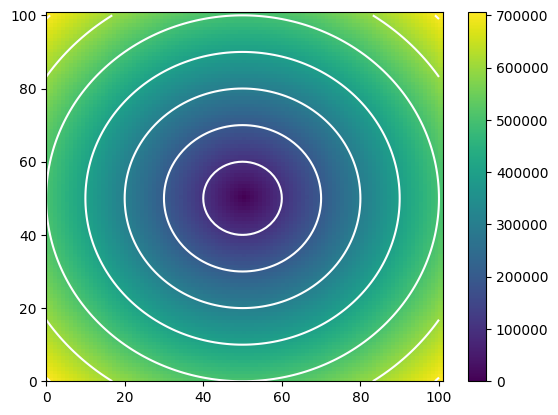

In [8]:
F = np.abs(np.hypot(uICE0, vICE0) - np.hypot(uICE, vICE))
plt.pcolor(F.T)
plt.colorbar()
plt.contour(F.T, colors='w')

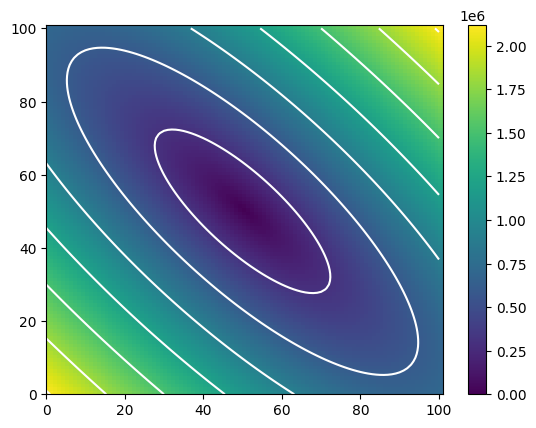

In [9]:
F = np.abs(np.hypot(uIEE0, vIEE0) - np.hypot(uIEE, vIEE))
plt.pcolor(F.T)
plt.colorbar()
plt.contour(F.T, colors='w')